<a id='top'></a><a name='top'></a>
# Chapter 4: Finding meaning in word counts (semantic analysis)

## 4.4 Principal component analysis

* [Introduction](#introduction)
* [4.0 Imports and Setup](#4.0)
* [4.4 Principal component analysis](#4.4)
    - [4.4.1 PCA on 3D vectors](#4.4.1)
    - [4.4.2 Stop horsing around and get back to NLP](#4.4.2)
    - [4.4.3 Using PCA for SMS message semantic analysis](#4.4.3)
    - [4.4.4 Using truncated SVD for SMS message semantic analysis](#4.4.4)
    - [4.4.5 How well does LSA work for spam classification?](#4.4.5)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Datasets

* pointcloud.csv.gz: [script](#pointcloud.csv.gz), [source](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/pointcloud.csv.gz)
* sms-spam.csv: [script](#sms-spam.csv), [source](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/sms-spam.csv)
* horse.ply: [script](#horse.ply), [source](https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/horse.ply)


### Explore

* Analyzing semantics (meaning) to create topic vectors
* Semantic search using the similarity between topic vectors
* Scalable semantic analysis and semantic search for large copora
* Using semantic components (topics) as features in your NLP pipeline
* Navigating high-dimensional vector spaces


### Key points

* You can use SVD for semantic analysis to decompose and transform TF-IDF
* Use LDiA when you need to compute explainable topic vectors
* No matter how you create your topic vectors, they can be used for semantic search to find documents based on their meaning
* Topic vectors can be used to predict whether a social post is spam or is likely to be "liked"
* We can sidestep the curse of dimensionality to approximate nearest neighbors in a semantic vector space

---

Principal component analysis is another name for SVD when it’s used for dimension reduction, like you did to accomplish your latent semantic analysis earlier. And the PCA model in scikit-learn has some tweaks to the SVD math that will improve the accuracy of your NLP pipeline.

For one, sklearn.PCA automatically “centers” your data by subtracting off the mean word frequencies. Another, more subtle trick is that PCA uses a function called flip_sign to deterministically compute the sign of the singular vectors.

Finally, the sklearn implementation of PCA implements an optional “whitening” step. This is similar to your trick of ignoring the singular values when transforming word-document vectors into topic-document vectors. Instead of just setting all the sin- gular values in S to one, whitening divides your data by these variances just like the sklearn.StandardScaler transform does. This helps spread out your data and makes any optimization algorithm less likely to get lost in “half pipes” or “rivers” of your data that can arise when features in your dataset are correlated with each other.

Before you apply PCA to real-world, high-dimensional NLP data, let’s take a step back and look at a more visual representation of what PCA and SVD do. This will also help you understand the API for the scikit-learn PCA implementation. PCA is useful for a wide range of applications, so this insight will be helpful for more than just NLP. You’re going to do PCA on a 3D point cloud before you try it out on high-dimensional natural language data.

For most “real” problems, you’ll want to use the sklearn.PCA model for your latent semantic analysis. The one exception is if you have more documents than you can hold in RAM. In that case, you’ll need to use the IncrementalPCA model in sklearn or some of the scaling techniques we talk about in chapter 13.


---
<a name='4.0'></a><a id='4.0'></a>
# 4.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
import os
if not os.path.exists('setup'):
    os.mkdir('setup')

In [2]:
req_file = "setup/requirements_04.txt"

In [3]:
%%writefile {req_file}
isort
pugnlp
plyfile
scikit-learn-intelex
scrapy
watermark

Overwriting setup/requirements_04.txt


In [4]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
# Running sklearnex with PCA consumes too much memory locally,
# limit running to COLAB platform
if IS_COLAB:
    from sklearnex import patch_sklearn
    patch_sklearn()

In [8]:
%%writefile setup/chp04_4.4_imports.py
import locale
import os
import pprint
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from plyfile import PlyData
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from watermark import watermark

Overwriting setup/chp04_4.4_imports.py


In [7]:
!isort setup/chp04_4.4_imports.py --sl
!cat setup/chp04_4.4_imports.py

import locale
import os
import pprint
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from plyfile import PlyData
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from watermark import watermark


In [9]:
import locale
import os
import pprint
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import casual_tokenize
from nltk.tokenize.casual import casual_tokenize
from plyfile import PlyData
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from watermark import watermark

In [9]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
np.seterr(invalid='warn')
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)
random.seed(42)
np.random.seed(42)

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

pandas    : 1.5.3
seaborn   : 0.12.1
sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]
matplotlib: 3.6.2
numpy     : 1.23.5



---
<a name='4.4'></a><a id='4.4'></a>
# 4.4 Principal component analysis (PCA)
<a href="#top">[back to top]</a>

Problem: How can we use PCA for real-world high dimensional NLP data?

Idea: Use the PCA model in sklearn-learn for latent semantic analysis, since it has some improvements to the SVD math that can improve the accuracy of the NLP pipeline.

<a name='4.4.1'></a><a id='4.4.1'></a>
## 4.4.1 PCA on 3D vectors
<a href="#top">[back to top]</a>

Problem: How to create a visual representation of data that has its dimensions reduced to 3D?

Idea: Use sklearn.PCA

Importance: sklearn.PCA (really SVD) preserves the structure and information content of vectors by maximizing the variance along the dimensions of the lower-dimensional "shadow" of the high-dimensional space. This captures the "essence" of whatever it represents. SVD maximizes the variance along each axis, and this variance represents the maximum "information" or "essence" in the data.

<a id='pointcloud.csv.gz'></a><a name='pointcloud.csv.gz'></a>
### Dataset: pointcloud.csv.gz
<a href="#top">[back to top]</a>

<a name='data_pointcloud'></a><a id='data_pointcloud'></a>

In [10]:
data_dir = 'data/data_pointcloud'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_pointcloud = f'{data_dir}/pointcloud.csv.gz'
!wget -P {data_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/pointcloud.csv.gz
!ls -l {data_pointcloud}

File ‘data/data_pointcloud/pointcloud.csv.gz’ already there; not retrieving.

-rw-r--r--  1 gb  staff  1285927 Mar 25 11:18 data/data_pointcloud/pointcloud.csv.gz


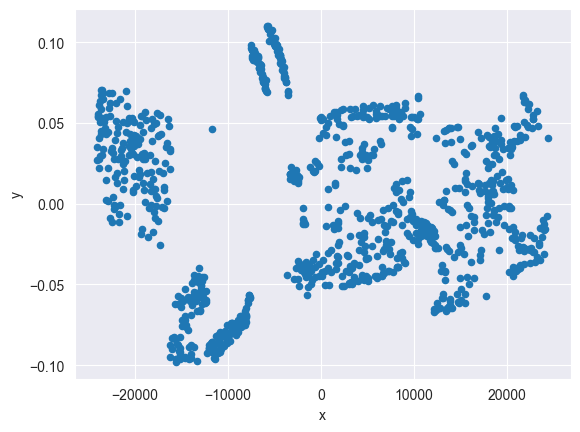

In [11]:
df = pd.read_csv(data_pointcloud).sample(1000)

pca = PCA(n_components=2)

df2d = pd.DataFrame(
    pca.fit_transform(df), 
    columns=list('xy')
)

df2d.plot(kind='scatter', x='x', y='y')
plt.show()

<a id='horse.ply'></a><a name='horse.ply'></a>
### Dataset: horse.ply
<a href="#top">[back to top]</a>

In [12]:
data_dir = 'data/data_horse'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_horseply = f"{data_dir}/horse.ply"
!wget -P {data_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/horse.ply
type(data_horseply)

File ‘data/data_horse/horse.ply’ already there; not retrieving.



str

,x,y,z
0,-0.002022,-0.040179,-0.000863
1,0.000403,-0.062019,-0.005498
2,-0.002863,-0.060056,-0.009567
3,-0.001945,-0.041256,-0.001349
4,-0.001867,-0.042348,-0.001900
...,...,...,...
48480,-0.000492,-0.051988,-0.006036
48481,-0.000473,-0.060511,-0.015761
48482,0.000096,-0.059130,-0.013502
48483,0.000209,-0.060391,-0.015222


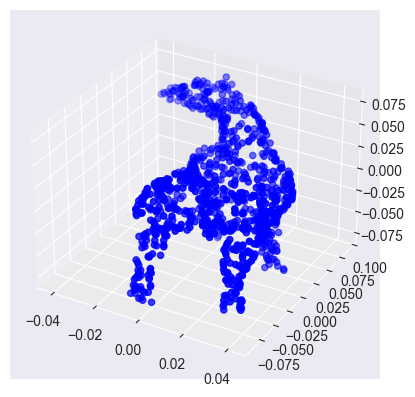

In [13]:
# from horse_plot.py
# plydata is a library that provides a grammar for data manipulation.
def ply_df(plyfile=data_horseply):
    horse = PlyData.read(plyfile)
    points = np.array(horse.elements[0].data)
    points = np.array([row.tolist() for row in points])
    df = pd.DataFrame(points[:, :3], columns='x y z'.split())
    return df

def plot_ply(plyfile=data_horseply):
    h = pd.read_csv(data_pointcloud, header=0, index_col=0)
    h = pd.DataFrame(h, columns='x y z'.split())
    h = h.sample(1000).copy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(h.x, h.y, h.z, c='b', zdir='z', depthshade=True)

plot_ply()
ply_df()

<a name='4.4.2'></a><a id='4.4.2'></a>
## 4.4.2 Stop horsing around and get back to NLP
<a href="#top">[back to top]</a>

Problem: Test how well SVD works on natural language documents. 

Idea: Find the principal components using SVD on 5,000 messages labeled as spam (or not). Also compare a PCA model against a truncated SVD model to see if there are any differences. The trunacated SVD model is designed to work with sparse matrices. 

<a id='sms-spam.csv'></a><a name='sms-spam.csv'></a>
### Dataset: sms-spam.csv
<a href="#top">[back to top]</a>

In [14]:
data_dir = 'data/data_sms_spam'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
data_sms_spam = f"{data_dir}/sms-spam.csv"
!wget -P {data_dir} -nc https://github.com/totalgood/nlpia/raw/master/src/nlpia/data/sms-spam.csv
!ls -l {data_sms_spam}

File ‘data/data_sms_spam/sms-spam.csv’ already there; not retrieving.

-rw-r--r--  1 gb  staff  493232 Mar 25 11:17 data/data_sms_spam/sms-spam.csv


In [15]:
sms_src = pd.read_csv(data_sms_spam, index_col=0)
sms_src.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
index = ['sms{}{}'.format(i, '!' * j) for (i, j) in zip(range(len(sms_src)), sms_src.spam)]

sms = pd.DataFrame(
    sms_src.values, 
    columns=sms_src.columns, 
    index=index
)

sms['spam'] = sms.spam.astype(int)

print(len(sms))
print(sms.spam.sum())

sms.head(6)

4837
638


,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


Calculate the TF-IDF vectors for each of these messages.

In [17]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
print(type(tfidf))
HR()

tfidf_docs = tfidf.fit_transform(
    raw_documents=sms.text
).toarray()

print(type(tfidf_docs))
HR()
print(len(tfidf.vocabulary_))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
----------------------------------------
<class 'numpy.ndarray'>
----------------------------------------
9232


In [18]:
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean()
tfidf_docs.shape

(4837, 9232)

In [19]:
sms.spam.sum()

638

<a name='4.4.3'></a><a id='4.4.3'></a>
## 4.4.3 Using PCA for SMS message semantic analysis
<a href="#top">[back to top]</a>

Problem: Test a PCA model that is limited to dense input. 

Idea: Use `sklearn.decomposition.PCA` class from scikit-learn. 

Importance: `sklearn.decomposition.PCA` centers but does not scale the input data for each feature before applying the SVD.

In [20]:
%%time
pca = PCA(n_components=16)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)

CPU times: user 6.71 s, sys: 743 ms, total: 7.45 s
Wall time: 3.37 s


In [21]:
columns = [
    'topics{}'.format(i) 
    for i in range(pca.n_components)
]

pca_topic_vectors = pd.DataFrame(
    pca_topic_vectors,
    columns=columns,
    index=index
)
pca_topic_vectors.round(3).head(6)

,topics0,topics1,topics2,topics3,topics4,topics5,topics6,topics7,topics8,topics9,topics10,topics11,topics12,topics13,topics14,topics15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.011,-0.085,0.005,-0.011,-0.000,-0.026,-0.020,0.045
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.065,0.025,-0.024,-0.003,0.035,0.047,-0.026,0.049,-0.043
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.000,-0.058,0.050,0.128,0.026,0.035,-0.021,-0.053,0.051
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.165,-0.076,0.060,-0.109,0.019,0.014,0.074,-0.032,0.023,-0.068
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,-0.044,0.062,-0.044,0.028,0.028,-0.010,0.018,0.041,-0.075,-0.027
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.005,0.166,-0.023,0.061,0.038,0.056,-0.046,0.076,-0.000,0.034


In [22]:
# Weights of the fitted sklearn transformation
print(pca.components_.shape)
HR()
pca.components_.round(2)[:5]

(16, 9232)
----------------------------------------


array([[-0.07,  0.01, -0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.06,  0.01,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.07,  0.03,  0.  , ..., -0.  , -0.  , -0.  ],
       [-0.06, -0.03, -0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.38, -0.01,  0.  , ...,  0.  ,  0.  ,  0.  ]])

Assign words to all the dimensions in the PCA transformation.

In [23]:
for i, x in enumerate(tfidf.vocabulary_.items()):
    print(x)
    if i > 5:
        break

('go', 3807)
('until', 8487)
('jurong', 4675)
('point', 6296)
(',', 13)
('crazy', 2549)
('..', 21)


In [24]:
column_names, terms = zip(*sorted(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys())))
terms[:10]

('!', '"', '#', '#150', '#5000', '$', '%', '&', "'", '(')

Create a DataFrame containing the weights, with labels for the columns and rows.

In [25]:
weights = pd.DataFrame(
    pca.components_, 
    columns=terms, 
    index=['topic{}'.format(i) for i in range(16)]
)
weights.head().round(3)

,!,"""",#,#150,#5000,$,%,&,',(,...,ü'll,–,—,‘,’,“,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,-0.001,0.003,-0.000,-0.012,-0.007,-0.005,...,0.003,-0.000,-0.0,-0.004,-0.001,-0.001,-0.002,0.001,0.001,0.001
topic1,0.064,0.008,0.000,-0.000,-0.001,-0.001,-0.002,-0.016,-0.016,0.001,...,0.002,0.001,-0.0,0.004,-0.001,-0.001,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,0.002,0.000,0.001,0.059,0.008,0.019,...,0.000,0.001,-0.0,0.002,0.000,0.001,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,-0.001,0.001,-0.003,-0.028,0.001,-0.010,...,-0.001,-0.001,0.0,0.000,-0.000,-0.000,0.001,0.000,0.000,0.000
topic4,0.381,-0.009,0.001,0.001,0.004,0.003,-0.001,0.068,0.002,0.020,...,0.000,-0.000,0.0,0.000,0.001,0.001,0.002,0.001,0.001,0.001


In [26]:
pd.options.display.max_columns = 12
deals = weights['! ;) :) half off free crazy deal only $ 80 %'.split()].round(3) * 100
deals

,!,;),:),half,off,free,crazy,deal,only,$,80,%
topic0,-7.1,0.1,-0.5,-0.0,-0.4,-2.0,-0.0,-0.1,-2.2,0.3,-0.0,-0.0
topic1,6.4,0.0,7.4,0.1,0.4,-2.3,-0.2,-0.1,-3.8,-0.1,-0.0,-0.2
topic2,7.1,0.2,-0.1,0.1,0.3,4.4,0.1,-0.1,0.7,0.0,0.0,0.1
topic3,-5.9,-0.3,-7.0,0.2,0.3,-0.2,0.0,0.1,-2.3,0.1,-0.1,-0.3
topic4,38.1,-0.1,-12.4,-0.1,-0.2,9.9,0.1,-0.2,3.0,0.3,0.1,-0.1
topic5,-26.4,0.1,-1.5,-0.4,-0.7,-1.4,-0.6,-0.2,-1.8,-0.9,0.0,0.0
topic6,-10.8,-0.5,19.9,-0.4,-0.9,-0.6,-0.2,-0.1,-1.4,-0.0,-0.0,-0.1
topic7,15.6,0.1,-18.2,0.8,0.8,-2.9,0.0,0.1,-1.9,-0.3,0.0,-0.1
topic8,34.5,0.1,4.1,-0.4,-0.5,-0.1,-0.4,-0.4,3.1,-0.6,-0.0,-0.2
topic9,7.6,-0.3,16.3,1.5,-0.9,6.4,-0.5,-0.4,3.2,-0.5,-0.0,-0.0


In [27]:
deals.T.sum()

topic0    -11.9
topic1      7.6
topic2     12.8
topic3    -15.4
topic4     38.4
topic5    -33.8
topic6      4.9
topic7     -6.0
topic8     39.2
topic9     32.4
topic10   -29.2
topic11    49.6
topic12    14.6
topic13    45.9
topic14    24.7
topic15    -1.5
dtype: float64

<a name='4.4.4'></a><a id='4.4.4'></a>
## 4.4.4 Using truncated SVD for SMS message semantic analysis
<a href="#top">[back to top]</a>

Problem: Test a transformer that can work with large sparse matrices efficiently.

Idea: Use sklearn.decomposition.TruncatedSVD model.

Importance: This transformer performs linear dimensionality reduction via truncated SVD. As opposed to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In [28]:
svd = TruncatedSVD(n_components=16, n_iter=100)
svd.__dict__

{'algorithm': 'randomized',
 'n_components': 16,
 'n_iter': 100,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'tol': 0.0}

In [29]:
%%time
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)

CPU times: user 1min 13s, sys: 4.71 s, total: 1min 18s
Wall time: 35.4 s


In [30]:
svd.__dict__

{'algorithm': 'randomized',
 'n_components': 16,
 'n_iter': 100,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'tol': 0.0,
 'n_features_in_': 9232,
 'components_': array([[-7.11100267e-02,  8.18303798e-03, -1.21149493e-03, ...,
          5.71862277e-04,  5.71862277e-04,  5.71862277e-04],
        [ 6.35131655e-02,  7.60675909e-03,  2.67217795e-04, ...,
          1.02166270e-03,  1.02166270e-03,  1.02166270e-03],
        [ 7.07958542e-02,  2.68823196e-02,  1.33292611e-04, ...,
         -9.53245383e-04, -9.53245383e-04, -9.53245383e-04],
        ...,
        [ 1.36639653e-01, -3.87606089e-02,  2.68147360e-03, ...,
          3.28271236e-04,  3.28271236e-04,  3.28271236e-04],
        [-1.99163745e-02, -9.36580667e-04,  6.95620884e-04, ...,
          5.65316290e-04,  5.65316290e-04,  5.65316290e-04],
        [-1.16434485e-02, -3.32933231e-02,  1.52927081e-04, ...,
         -7.91270178e-04, -7.91270178e-04, -7.91270178e-04]]),
 'explained_variance_': arr

In [31]:
type(svd_topic_vectors)

numpy.ndarray

In [32]:
svd_topic_vectors = pd.DataFrame(
    svd_topic_vectors,
    columns=columns,
    index=index
)
svd_topic_vectors.round(3).head(6)

,topics0,topics1,topics2,topics3,topics4,topics5,...,topics10,topics11,topics12,topics13,topics14,topics15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,...,0.007,-0.007,0.002,-0.036,-0.014,0.037
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,...,-0.004,0.036,0.043,-0.021,0.051,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,...,0.125,0.023,0.026,-0.020,-0.042,0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,...,0.022,0.023,0.073,-0.046,0.022,-0.070
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,...,0.028,-0.009,0.027,0.034,-0.083,-0.021
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,...,0.041,0.055,-0.037,0.075,-0.001,0.020


<a name='4.4.5'></a><a id='4.4.5'></a>
## 4.4.5 How well does LSA work for spam classification?
<a href="#top">[back to top]</a>

Problem: Find out how well a vector space model works for classification.

Idea: Examine how cosine similarities between vectors (eg corresponding pairs of documents) correlate with membership in the same class. We should see a larger positive cosine simmilarity (dot product) between any spam message.

In [33]:
svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(svd_topic_vectors, axis=1)).T
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

,sms0,sms1,sms2!,sms3,sms4,sms5!,sms6,sms7,sms8!,sms9!
sms0,1.0,0.6,-0.1,0.6,-0.0,-0.3,-0.3,-0.1,-0.3,-0.3
sms1,0.6,1.0,-0.2,0.8,-0.2,0.0,-0.2,-0.2,-0.1,-0.1
sms2!,-0.1,-0.2,1.0,-0.2,0.1,0.4,0.0,0.3,0.5,0.4
sms3,0.6,0.8,-0.2,1.0,-0.2,-0.3,-0.1,-0.3,-0.2,-0.1
sms4,-0.0,-0.2,0.1,-0.2,1.0,0.2,0.0,0.1,-0.4,-0.2
sms5!,-0.3,0.0,0.4,-0.3,0.2,1.0,-0.1,0.1,0.3,0.4
sms6,-0.3,-0.2,0.0,-0.1,0.0,-0.1,1.0,0.1,-0.2,-0.2
sms7,-0.1,-0.2,0.3,-0.3,0.1,0.1,0.1,1.0,0.1,0.4
sms8!,-0.3,-0.1,0.5,-0.2,-0.4,0.3,-0.2,0.1,1.0,0.3
sms9!,-0.3,-0.1,0.4,-0.1,-0.2,0.4,-0.2,0.4,0.3,1.0
